In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import utils
import skutils
import pandas as pd

TRAIN_DATA = "../../data/train.csv"
TEST_DATA = "../../data/test.csv"

# Load the training data
train = pd.read_csv(TRAIN_DATA)

# Load the testing data
test = pd.read_csv(TEST_DATA)

In [2]:
# Get uniques
uniques = train.apply(lambda x: len(x.unique()))

def transform(data, threshold_unimportant=0.0000001):
    
    cols_emtpy = list(uniques[uniques == 1].index.values)
    
    # We have to remove the correlated ones by hand
    # because there can be multiple correlations with one column
    cols_correlated = [
        'ind_var1', 'ind_var1_0',
        'ind_var5',
        'ind_var6', 'ind_var6_0', 'num_var6',
        'ind_var8', 'ind_var8_0',
        'ind_var12',
        'ind_var13_corto', 'ind_var13_corto_0', 'ind_var13_medio', 'ind_var13_medio_0',
        'ind_var18', 'ind_var18_0', 'num_var18', 'num_var18_0',
        'ind_var20', 'ind_var20_0',
        'ind_var29', 'ind_var29_0',
        'ind_var24', 'ind_var24_0',
        'ind_var25_0', 'num_var25_0',
        'ind_var26_0', 'num_var26_0',
        'ind_var32_0', 'num_var32_0',
        'ind_var34', 'ind_var34_0', 'num_var34', 'num_var34_0',
        'ind_var37_0', 'num_var37_0',
        'ind_var39',
        'ind_var40', 'num_var40',
        'ind_var44',
        'num_var29_0',
        'num_var13_medio', 'num_var13_medio_0',
        'num_var7_emit_ult1',
        'num_var39',
        'num_var40_0',
        'num_var44_0',
        'saldo_var6',
        'saldo_var18',
        'saldo_var13_medio',
        'saldo_medio_var17_ult3',
        'saldo_medio_var33_ult1',
        'delta_imp_aport_var13_1y3', 'delta_imp_reemb_var13_1y3', 'delta_num_reemb_var13_1y3',
        'delta_imp_aport_var17_1y3', 'delta_imp_reemb_var17_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3',
        'delta_imp_aport_var33_1y3', 'delta_imp_reemb_var33_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var33_out_1y3',
        'delta_imp_compra_var44_1y3', 'delta_imp_venta_var44_1y3',
        'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var17_out_1y3',
        'delta_imp_trasp_var33_in_1y3', 'delta_imp_trasp_var33_out_1y3',
        'imp_reemb_var17_hace3',
        'imp_reemb_var33_ult1', 'imp_trasp_var33_out_ult1',
        'num_med_var45_ult3',
        'imp_op_var39_efect_ult1',
        'imp_op_var39_efect_ult3',
        'imp_op_var39_ult1',
        'imp_amort_var18_ult1',
        'saldo_medio_var17_hace3', 'saldo_medio_var17_ult1',
        'saldo_medio_var13_medio_ult3',
    ]

    # Extract the ids
    ids = data['ID']
    
    # Extract the data
    X = data.drop(['ID'] + cols_emtpy + cols_correlated,  axis=1)
    if 'TARGET' in data.columns:
        X.drop('TARGET', axis=1, inplace=True)

    # Extract the labels
    y = data['TARGET'] if 'TARGET' in data.columns else None
    
    return ids, X, y

In [3]:
from sklearn.metrics import roc_auc_score

# Learning Rates with decay function
def learning_rates(steps, start=1, end=0, start_exp_x=0.0, end_exp_x=7.0):
    return end + np.exp(-np.linspace(start_exp_x, end_exp_x, steps)) * (start - end)

def cross_validate_xgb(X_train, y_train, parms, fit_params={}, folds=None, scorer=roc_auc_score):

    if folds is None:
        folds = skutils.folds(y_train, n_folds=4, stratified=True)
    
    scores = []
    for train_idx, test_idx in folds:

        clf = xgb.XGBClassifier(**parms)
        
        # Needs latest XGBoost from chaosmail
        # https://github.com/chaosmail/xgboost
        # Build Instructions: https://github.com/dmlc/xgboost/blob/master/doc/build.md
        # https://github.com/dmlc/xgboost/pull/1018
        clf.fit(X_train.values[train_idx], y_train.values[train_idx], verbose=False, **fit_params)
        
        # Predict the output
        y_predict = clf.predict_proba(X_train.values[test_idx], ntree_limit=clf.best_iteration)[:,1]
        
        # Compute a score
        scores.append(scorer(y_train.values[test_idx], y_predict))
    
    return np.mean(scores), np.std(scores)

# Create Test Dataset

In [4]:
from sklearn.cross_validation import ShuffleSplit

# Transform the training data
Ids_train, X, y = transform(train)

folds = ShuffleSplit(len(y), random_state=2, n_iter=20, test_size=0.1)

for train_idx, test_idx in folds:
    X_train_, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_, y_test = y[train_idx], y[test_idx]

## Data cleaning

The more happy customers in our training set, the more the classifier will overfit for this target group. Hence we need to remove some of thos values from the training set

In [5]:
fzeros = 0.82
X_train, y_train = skutils.random_subset(X_train_, y_train_, dims=[(0, fzeros), (1, 1.0)])

# Create a XGB Classifier

## Learning Rates

Instead of a simple Learning Rates, we want to have fast converging and smooth decay - hence we just build up our custom learning rates function

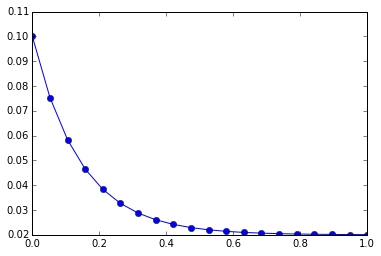

In [6]:
# Plot the learning rates
steps = 20
fig = plt.figure()
plt.plot(np.linspace(0, 1, steps), learning_rates(steps, start=0.1, end=0.02), marker='o')

In [8]:
from hyperopt import hp
import xgboost as xgb
import numpy as np

# In the end we will use this amount of estimators
n_total_estimators = 500
n_cv_estimators = 250
seed = 42

params = {
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.9, 1),
    'learning_rate_start': hp.uniform('learning_rate_start', 0.1, 0.3),
    'learning_rate_end': hp.uniform('learning_rate_end', 0.01, 0.1),
    'seed': hp.quniform('seed', 1, 1000000),
}

fit_params = {
    'early_stopping_rounds': 20,
    'eval_metric': 'auc',
    'eval_set': [(X_test.values, y_test.values)],
}
# eval_set: set that is used for watching the training performance

# Tune the parameters of XGB

In [ ]:
from hyperopt import fmin, rand, hp, STATUS_OK, Trials

folds = skutils.folds(y_train, n_folds=4, stratified=True, random_state=seed)

def objective(params):
        
    cv_params = {
        'max_depth': int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'n_estimators': n_cv_estimators,
        'seed': seed,
    }
    
    def iter_learning_rates(i, n): 
        return learning_rates(
            n_total_estimators, start=params['learning_rate_start'], end=params['learning_rate_end']
        )[i]
        
    fit_params['learning_rates'] = iter_learning_rates
    
    score_mean, score_std = cross_validate_xgb(X_train, y_train, cv_params, fit_params, folds=folds)
    
    print("Cross validation test-auc-mean score %.8f (+- %.8f)" % (score_mean, score_std))

    return {
        'loss': 1 - score_mean,
        'loss_variance': score_std**2,
        'status': STATUS_OK,
        
        #'test-auc-mean': scores['test-auc-mean'],
        #'test-auc-std': scores['test-auc-std'],
        #'train-auc-mean': scores['train-auc-mean'],
        #'train-auc-std': scores['train-auc-std'],
    } 

trials = Trials()

# Needs latest hyperopt from chaosmail
# https://github.com/chaosmail/hyperopt
# https://github.com/hyperopt/hyperopt/issues/234
best = fmin(fn=objective, space=params, algo=rand.suggest, max_evals=100, trials=trials)

# Print the best result
print(best)

In [48]:
best

{'colsample_bytree': 0.9840611732060847,
 'learning_rate_end': 0.08303127679504986,
 'learning_rate_start': 0.11158443875324964,
 'max_depth': 4.0,
 'min_child_weight': 4.0,
 'subsample': 0.8057646474356563}

In [43]:
# Ooh Hack, I minimized the AUC score instead of minimizing the loss!
# Now i need to find the max and set it manualy
sorted_trials = sorted(trials.trials, key=lambda trial: trial['result']['loss'])

scores = sorted_trials[0]['result']

print("Cross validation test-auc-mean score %.8f (+- %.8f)" % (scores['acu-test-mean'], scores['acu-test-std']))
print("Cross validation train-auc-mean score %.8f (+- %.8f)" % (scores['acu-train-mean'], scores['acu-train-std']))
print(best)

# Compute Private Score

In [44]:
from sklearn.metrics import roc_auc_score

best_params = {
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': float(best['subsample']),
    'colsample_bytree': float(best['colsample_bytree']),
    'n_estimators': n_total_estimators,
    'seed': seed,
}

def iter_learning_rates(i, n): 
    return learning_rates(
        n, start=best['learning_rate_start'], end=best['learning_rate_end']
    )[i]

fit_params['learning_rates'] = iter_learning_rates

clf = xgb.XGBClassifier(**best_params)
clf.fit(X_train.values, y_train.values, **fit_params)

score = roc_auc_score(y_test.values, clf.predict_proba(X_test.values, ntree_limit=clf.best_iteration)[:,1])

print("Private Score %.8f" % score)

Will train until validation_0 error hasn't decreased in 20 rounds.

[0]	validation_0-auc:0.816003

[1]	validation_0-auc:0.823203

[2]	validation_0-auc:0.826731

[3]	validation_0-auc:0.828860

[4]	validation_0-auc:0.829577

[5]	validation_0-auc:0.831272

[6]	validation_0-auc:0.831710

[7]	validation_0-auc:0.832975

[8]	validation_0-auc:0.833394

[9]	validation_0-auc:0.834003

[10]	validation_0-auc:0.834220

[11]	validation_0-auc:0.834908

[12]	validation_0-auc:0.836941

[13]	validation_0-auc:0.836239

[14]	validation_0-auc:0.836225

[15]	validation_0-auc:0.835456

[16]	validation_0-auc:0.834879

[17]	validation_0-auc:0.835704

[18]	validation_0-auc:0.835653

[19]	validation_0-auc:0.835500

[20]	validation_0-auc:0.836221

[21]	validation_0-auc:0.835806

[22]	validation_0-auc:0.836845

[23]	validation_0-auc:0.836195

[24]	validation_0-auc:0.836413

[25]	validation_0-auc:0.836158

[26]	validation_0-auc:0.836486

[27]	validation_0-auc:0.836761

[28]	validation_0-auc:0.836701

[29]	validatio

# Make Submission

In [47]:
Ids_test_, X_test_, y_test_ = transform(test)

# Seriously, this must go in some preprocessing function!
X_, y_ = skutils.random_subset(X_train_, y_train_, dims=[(0, fzeros), (1, 1.0)])

fit_params['early_stopping_rounds'] = None
fit_params['eval_set'] = None

clf.fit(X_.values, y_.values, verbose=False, **fit_params)

y_pred = clf.predict_proba(X_test_.values, ntree_limit=clf.best_iteration)

submission = pd.DataFrame({"ID":Ids_test_, "TARGET":y_pred[:,1]})
submission.to_csv("submissions/submission_%s.csv" % utils.timestamp(), index=False)

# Public Score: 0.836881